In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, plotting
from collections import Counter

# plt.style.use('ggplot')
plt.style.use('bmh')
# mpl.use("pgf")
mpl.rcParams.update({
    "grid.linestyle" : "dashed",
    "axes.facecolor" : "white",
    "axes.spines.top" : False,
    "axes.spines.right" : False,
    "legend.frameon" : False,
    "figure.figsize" : (8, 5),

    # saving settings for latex
    # https://timodenk.com/blog/exporting-matplotlib-plots-to-latex/
    # "pgf.texsystem": "pdflatex",
    # "font.family": "serif",
    # "text.usetex": True,
    # "pgf.rcfonts": False,
    })

%matplotlib inline

In [25]:
# load the dataset and the extra data
df = pd.read_csv("./data/data/data_cvd.csv", index_col=0, decimal='.')
df["Follow Up Data"] = pd.to_datetime(df["Follow Up Data"], format="%Y/%m/%d")
df["Data prelievo (1)"] = pd.to_datetime(df["Data prelievo (1)"], format="%Y/%m/%d")

df_sub = pd.read_csv("./data/data/extra_subset.csv", index_col=0, decimal='.')
df_7y = pd.read_csv("./data/data/data_cvd_clean.csv", index_col=0, decimal='.')
df = df.merge(df_7y["Survive7Y"], how="left", left_index=True, right_index=True)
df = df.merge(df_sub["Classificazione pazienti"], how="left", left_index=True, right_index=True)

df["Death7Y"] = df["Survive7Y"].map(lambda x: (x+1)%2)
# df.info()

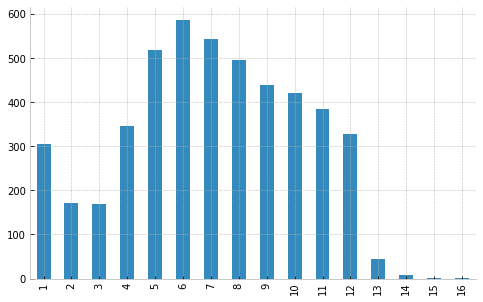

In [26]:
# birth event: "Data prelievo"
# death event: "Death7Y"
# right-censoring occur if the patient is still alive at "Follow Up Data"

# duration and observation features
df_surv = df.copy()
df_surv["duration"] = (df["Follow Up Data"] - df["Data prelievo (1)"]).map(lambda x: (x.days//365) + 1)
df_surv["observed"] = df["CVD Death"]
# df_surv["observed"] = df["Death7Y"]
# df_surv["observed"] = df["Survive7Y"]

# plot duration
df_surv["duration"].value_counts().sort_index().plot(kind='bar')


### 1- Survival Analysis On All The Patients
The plot indicates the % of CVD patients that survived after n years. For example, the probability for surviving more than 7 years is ~92%.

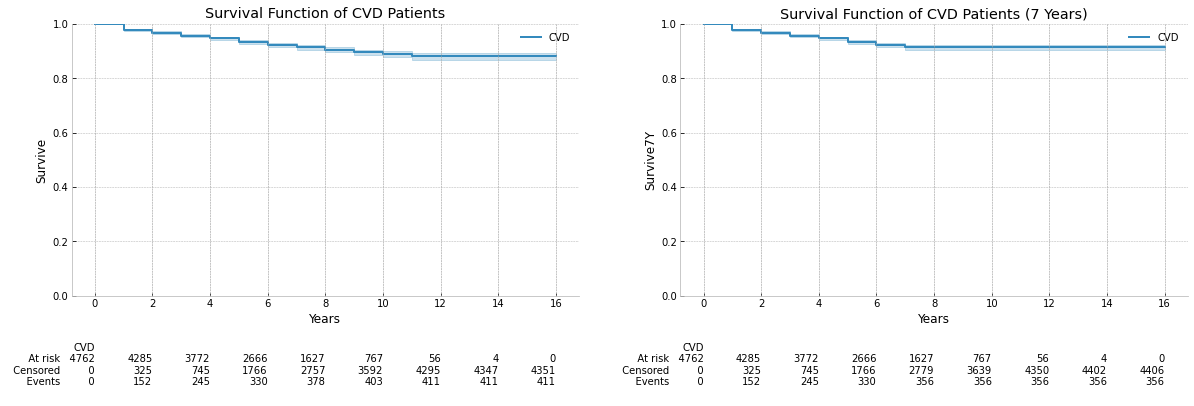

In [31]:
fig = plt.figure(figsize=(20, 5)) 
fig_dims = (1, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
kmf1 = KaplanMeierFitter()
kmf1.fit(df_surv["duration"], event_observed=df_surv["observed"], label="CVD")
kmf1.plot_survival_function()
plt.title('Survival Function of CVD Patients')
plt.xlabel("Years")
plt.ylabel("Survive")
plt.ylim(0, 1)
plotting.add_at_risk_counts(kmf1)

plt.subplot2grid(fig_dims, (0, 1))
kmf2 = KaplanMeierFitter()
kmf2.fit(df_surv["duration"], event_observed=df_surv["Death7Y"], label="CVD")
kmf2.plot_survival_function()
plt.title('Survival Function of CVD Patients (7 Years)')
plt.xlabel("Years")
plt.ylabel("Survive7Y")
plt.ylim(0, 1)
plotting.add_at_risk_counts(kmf2)

plt.savefig("")
# kmf.median_survival_time_
# kmf.confidence_interval_

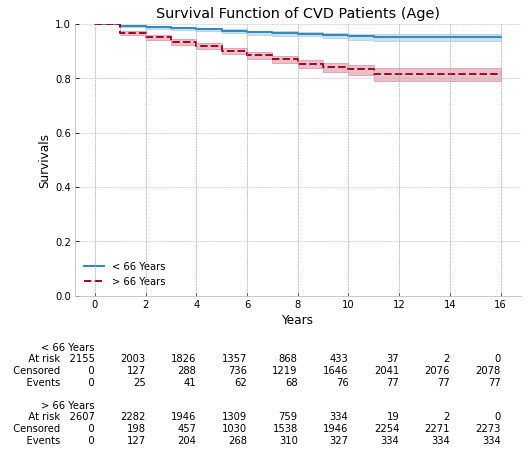

In [32]:
age_mean = df_surv["Age (1)"].mean()

df_under_mean = df_surv[df_surv["Age (1)"] < age_mean]
df_above_mean = df_surv[df_surv["Age (1)"] > age_mean]

kmf1 = KaplanMeierFitter()
kmf1.fit(df_under_mean["duration"], event_observed=df_under_mean["observed"], label="< 66 Years")
kmf1.plot_survival_function()

kmf2 = KaplanMeierFitter()
kmf2.fit(df_above_mean["duration"], event_observed=df_above_mean["observed"], label="> 66 Years")
kmf2.plot_survival_function(linestyle="--")

plt.title('Survival Function of CVD Patients (Age)')
plt.xlabel("Years")
plt.ylabel("Survivals")
plt.ylim(0, 1)
plotting.add_at_risk_counts(kmf1, kmf2)
# plt.tight_layout()

### 2- Survival Analysis Subsets

In [6]:
# patients for each subgroup
# - 6 Coronary Artery Disease
# - 5 Primary dilated cardiomyopathy
# - 4 Myocarditis, Pericarditis, Endocarditis
# - 3 Hypertension, Arrhythmias
df_6 = df_surv[df_surv["Classificazione pazienti"] == 6]
df_5 = df_surv[df_surv["Classificazione pazienti"] == 5]
df_4 = df_surv[df_surv["Classificazione pazienti"] == 4]
df_3 = df_surv[df_surv["Classificazione pazienti"] == 3]

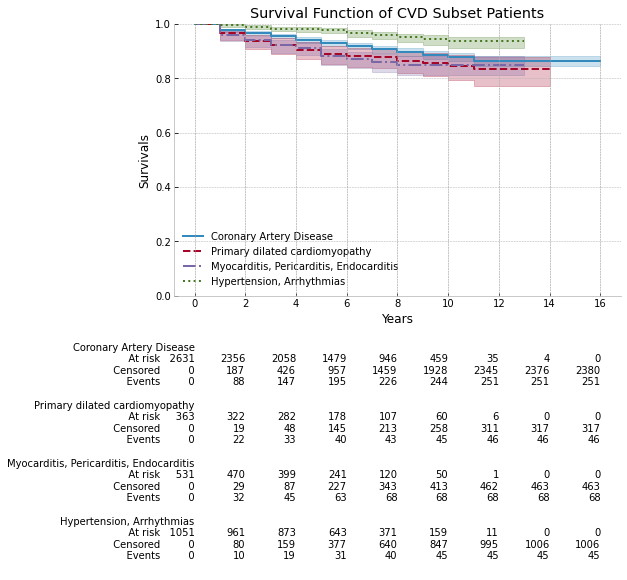

In [35]:

kmf6 = KaplanMeierFitter()
kmf6.fit(df_6["duration"], event_observed=df_6["observed"], label="Coronary Artery Disease")
kmf6.plot_survival_function()

kmf5 = KaplanMeierFitter()
kmf5.fit(df_5["duration"], event_observed=df_5["observed"], label="Primary dilated cardiomyopathy")
kmf5.plot_survival_function(linestyle="--")

kmf4 = KaplanMeierFitter()
kmf4.fit(df_4["duration"], event_observed=df_4["observed"], label="Myocarditis, Pericarditis, Endocarditis")
kmf4.plot_survival_function(linestyle="-.")

kmf3 = KaplanMeierFitter()
kmf3.fit(df_3["duration"], event_observed=df_3["observed"], label="Hypertension, Arrhythmias")
kmf3.plot_survival_function(linestyle=":")

plt.title("Survival Function of CVD Subset Patients")
plt.xlabel("Years")
plt.ylabel("Survivals")
plt.ylim(0, 1)
plotting.add_at_risk_counts(kmf6, kmf5, kmf4, kmf3)


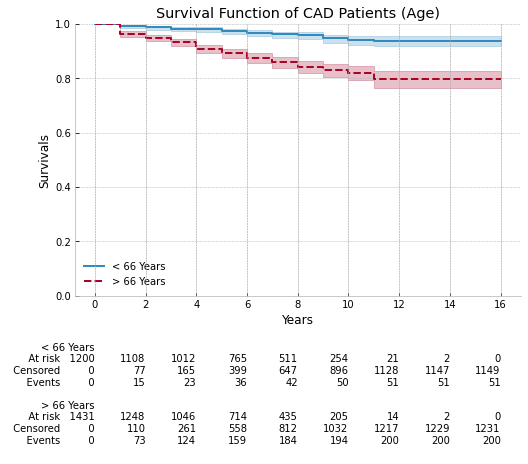

In [36]:
age_mean = df_6["Age (1)"].mean()

df_6_under_mean = df_6[df_6["Age (1)"] < age_mean]
df_6_above_mean = df_6[df_6["Age (1)"] > age_mean]

kmf1 = KaplanMeierFitter()
kmf1.fit(df_6_under_mean["duration"], event_observed=df_6_under_mean["observed"], label="< 66 Years")
kmf1.plot_survival_function()

kmf2 = KaplanMeierFitter()
kmf2.fit(df_6_above_mean["duration"], event_observed=df_6_above_mean["observed"], label="> 66 Years")
kmf2.plot_survival_function(linestyle="--")

plt.title('Survival Function of CAD Patients (Age)')
plt.xlabel("Years")
plt.ylabel("Survivals")
plt.ylim(0, 1)
plotting.add_at_risk_counts(kmf1, kmf2)

### 3- Survival Analysis Subsets (Model's Prediction)

In [37]:
# df_model = pd.read_csv("./data/data/extra_model_output.csv", index_col=0, decimal='.')

# df_6_model = df_6.drop(list(set(df_6.index) - set(df_model.index)))
# df_6_model = df_6_model.merge(df_model, how="left", left_index=True, right_index=True)
# df_6_model["ModelObserved"] = df_6_model["ModelOutput"] < 0.5

# # (df_6_model["ModelObserved"] == df_6_model["observed"]).sum() / len(df_6_model)

In [38]:
# fig = plt.figure(figsize=(20, 5)) 
# fig_dims = (1, 2)
# fig.subplots_adjust(hspace=0.2, wspace=0.2)

# # plot the first figure
# plt.subplot2grid(fig_dims, (0, 0))
# kmf1 = KaplanMeierFitter()
# kmf1.fit(df_6_model["duration"], event_observed=df_6_model["CVD Death"], label="CAD")
# kmf1.plot_survival_function()

# kmf2 = KaplanMeierFitter()
# kmf2.fit(df_6_model["duration"], event_observed=df_6_model["ModelObserved"], label="CAD (Prediction)")
# kmf2.plot_survival_function(linestyle="--")

# plt.title('Survival Function of CAD Patients (Model Prediction)')
# plt.xlabel("Years")
# plt.ylabel("Survivals")
# plotting.add_at_risk_counts(kmf1, kmf2)

# # plot the second figure
# # drop the last patient for zooming the viewing
# plt.subplot2grid(fig_dims, (0, 1))
# df_6_model_zoom = df_6_model.drop(df_6_model[df_6_model["duration"] == 16].index)

# kmf1 = KaplanMeierFitter()
# kmf1.fit(df_6_model_zoom["duration"], event_observed=df_6_model_zoom["CVD Death"], label="CAD")
# kmf1.plot_survival_function()

# kmf2 = KaplanMeierFitter()
# kmf2.fit(df_6_model_zoom["duration"], event_observed=df_6_model_zoom["ModelObserved"], label="CAD (Prediction)")
# kmf2.plot_survival_function(linestyle="--")

# plt.title('Survival Function of CAD Patients (Model Prediction)')
# plt.xlabel("Years")
# plt.ylabel("Survivals")
# plotting.add_at_risk_counts(kmf1, kmf2)

# # The model wrongly classify the patient 552 (Age=72, PMI=1, Duration=16), who did not die because of "CVD Death",
# # causing the sudden drop for the last value based on the KaplanMeier formula.
# # df_6_model[df_6_model["duration"] == 16]

### 4- Survival Analysis CAD Prediction Indicator (Valid and Test set)

In [49]:
def plot_kmf(threshold):
    df_6_model_under = df_6_model[df_6_model["ModelOutput"] <= threshold]
    df_6_model_above = df_6_model[df_6_model["ModelOutput"] > threshold]

    kmf1 = KaplanMeierFitter()
    kmf1.fit(df_6_model_under["duration"], event_observed=df_6_model_under["observed"], label=f"<= {threshold}")
    kmf1.plot_survival_function()

    kmf2 = KaplanMeierFitter()
    kmf2.fit(df_6_model_above["duration"], event_observed=df_6_model_above["observed"], label=f"> {threshold}")
    kmf2.plot_survival_function(linestyle="--")

    plt.title('Survival Function of CAD Patients (Model Prediction Indicator)')
    plt.xlabel("Years")
    plt.ylabel("Survivals")
    plt.ylim(0, 1)
    plotting.add_at_risk_counts(kmf1, kmf2)

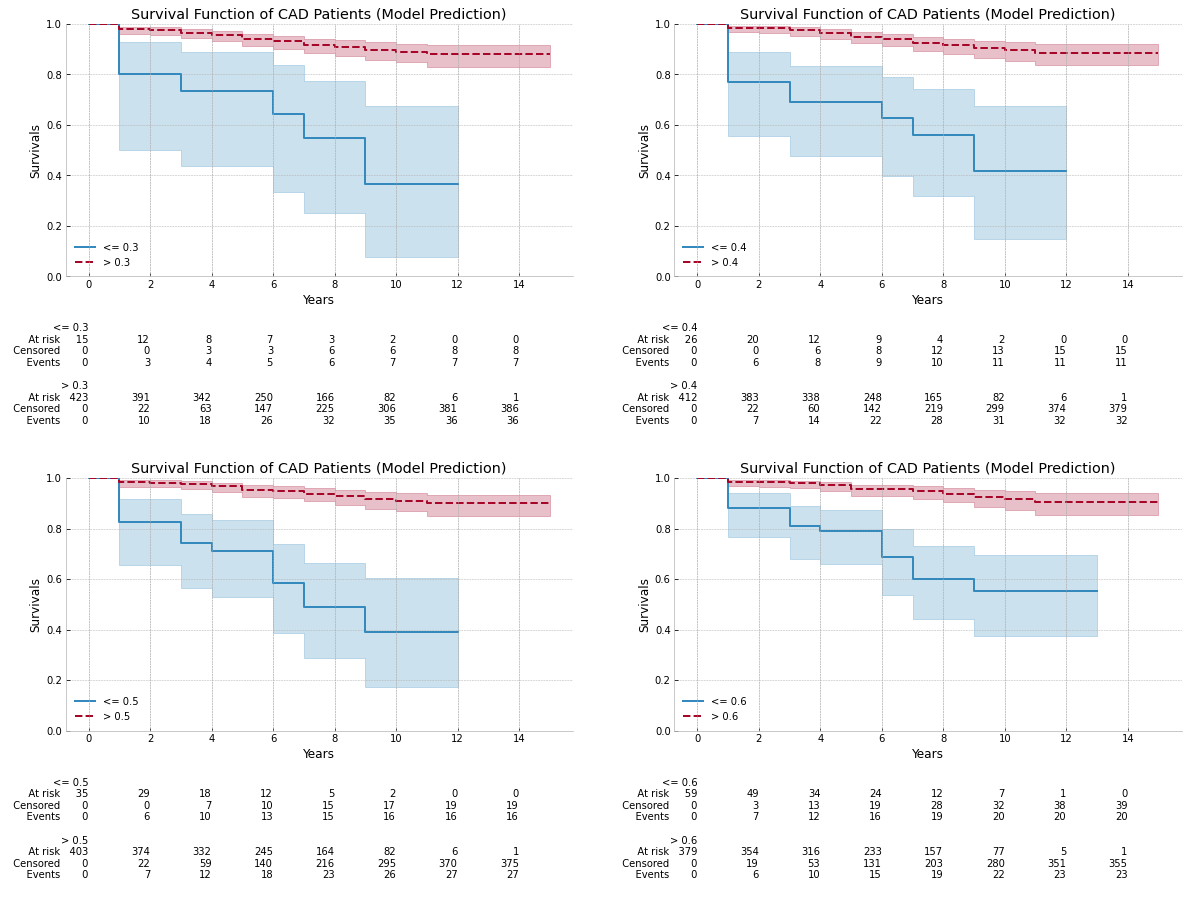

In [50]:
df_model = pd.read_csv("./data/data/survival/extra_model_valid_output.csv", index_col=0, decimal='.')

df_6_model = df_6.drop(list(set(df_6.index) - set(df_model.index)))
df_6_model = df_6_model.merge(df_model, how="left", left_index=True, right_index=True)


fig = plt.figure(figsize=(20, 13)) 
fig_dims = (2, 2)
fig.subplots_adjust(hspace=0.8, wspace=0.2)

# plot the first figure
plt.subplot2grid(fig_dims, (0, 0))
plot_kmf(threshold=0.3)

# plot the second figure
plt.subplot2grid(fig_dims, (0, 1))
plot_kmf(threshold=0.4)

# plot the third figure
plt.subplot2grid(fig_dims, (1, 0))
plot_kmf(threshold=0.5)

# plot the fourth figure
plt.subplot2grid(fig_dims, (1, 1))
plot_kmf(threshold=0.6)

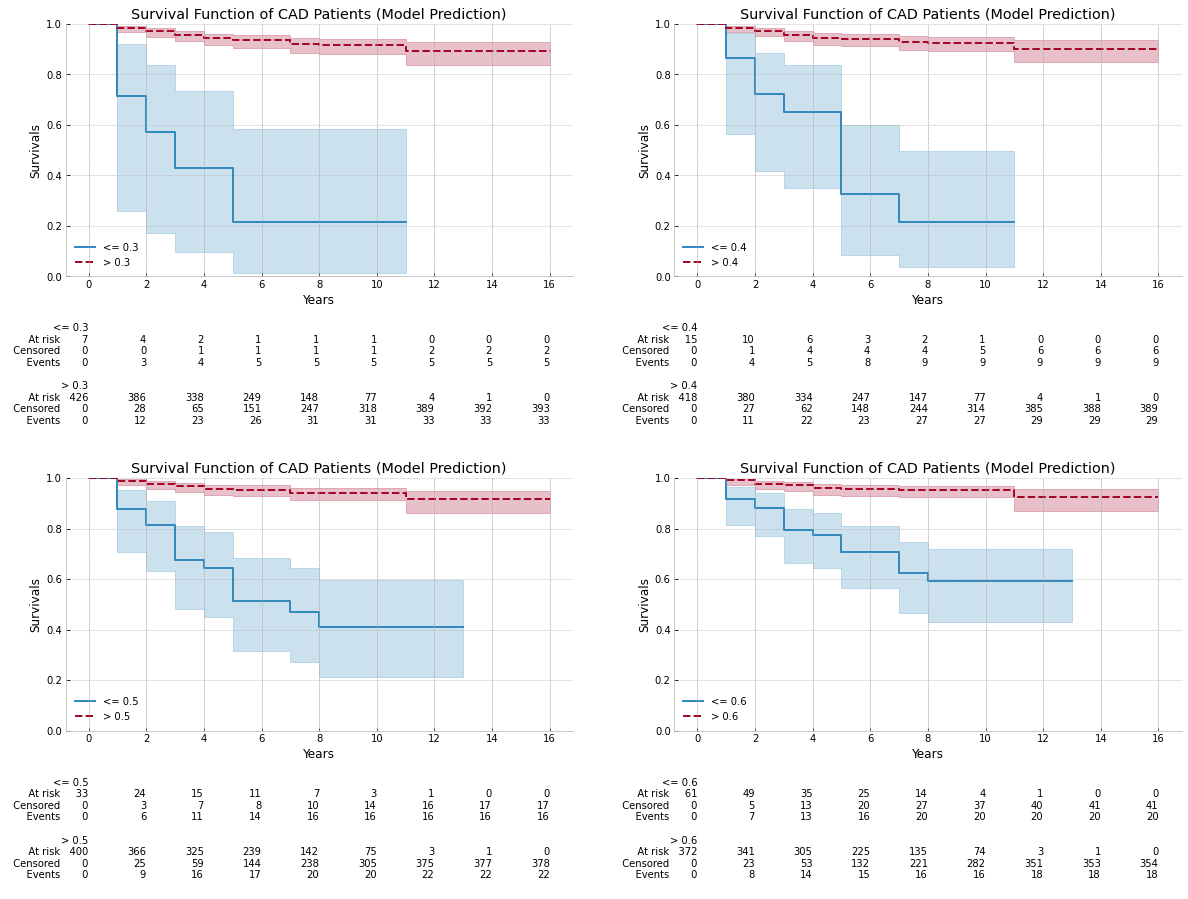

In [51]:
df_model = pd.read_csv("./data/data/survival/extra_model_test_output.csv", index_col=0, decimal='.')

df_6_model = df_6.drop(list(set(df_6.index) - set(df_model.index)))
df_6_model = df_6_model.merge(df_model, how="left", left_index=True, right_index=True)


fig = plt.figure(figsize=(20, 13)) 
fig_dims = (2, 2)
fig.subplots_adjust(hspace=0.8, wspace=0.2)

# plot the first figure
plt.subplot2grid(fig_dims, (0, 0))
plot_kmf(threshold=0.3)

# plot the second figure
plt.subplot2grid(fig_dims, (0, 1))
plot_kmf(threshold=0.4)

# plot the third figure
plt.subplot2grid(fig_dims, (1, 0))
plot_kmf(threshold=0.5)

# plot the fourth figure
plt.subplot2grid(fig_dims, (1, 1))
plot_kmf(threshold=0.6)


### 5- Survival Analysis CAD Prediction Indicator (No Meds) (Test set)

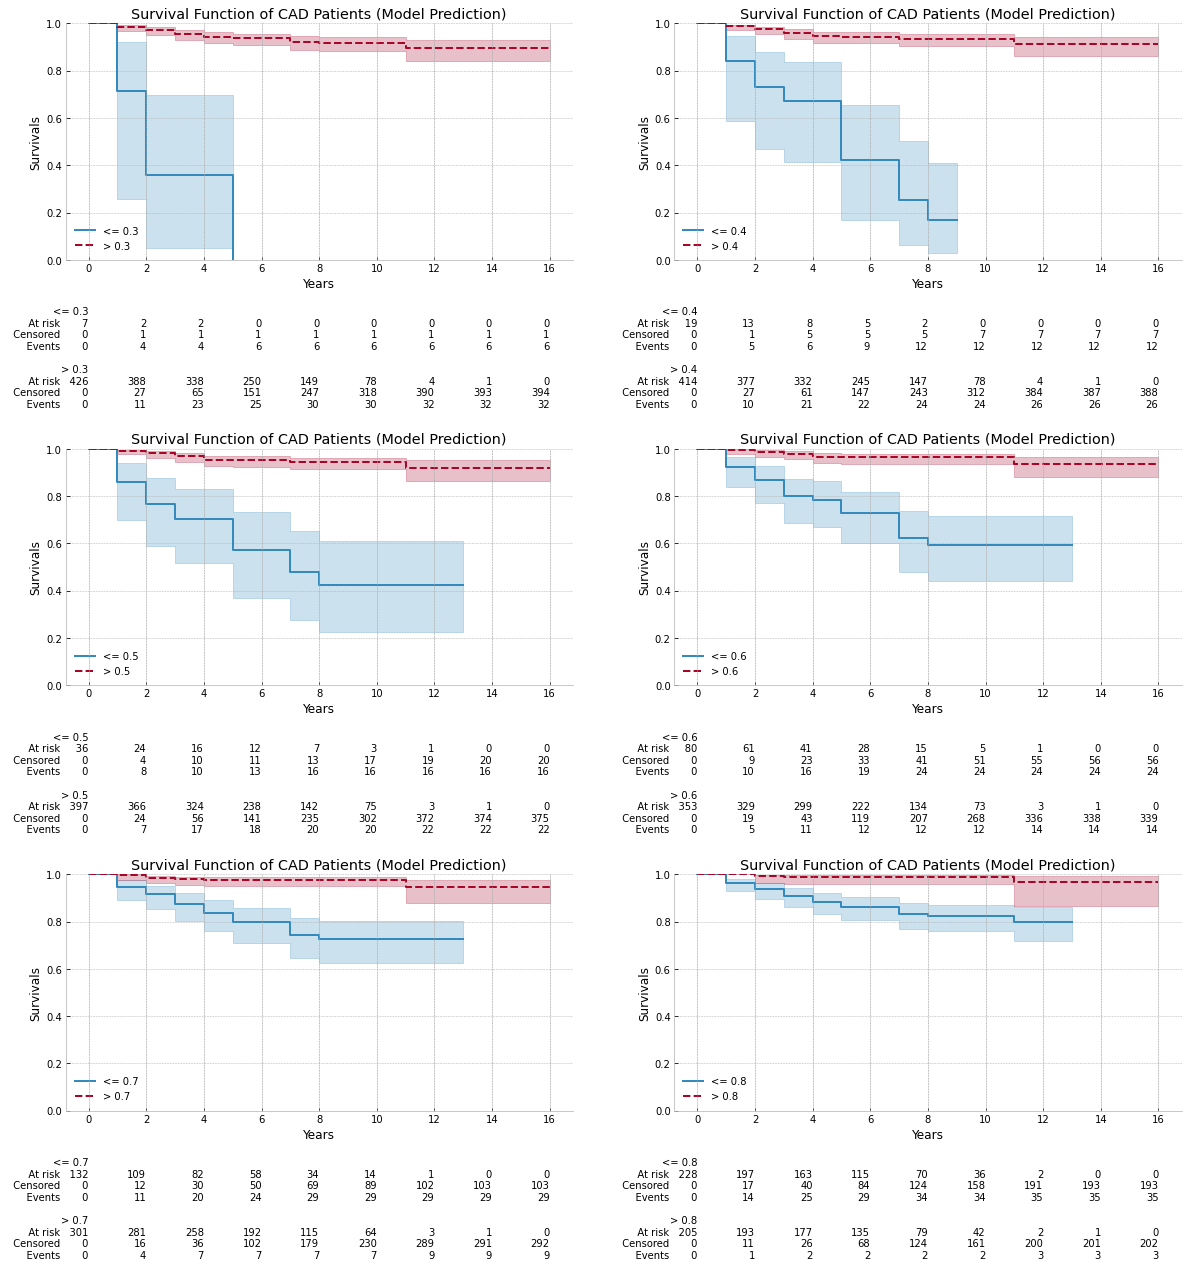

In [64]:
df_model = pd.read_csv("./data/data/survival/extra_nomeds_test_output.csv", index_col=0, decimal='.')

df_6_model = df_6.drop(list(set(df_6.index) - set(df_model.index)))
df_6_model = df_6_model.merge(df_model, how="left", left_index=True, right_index=True)


fig = plt.figure(figsize=(20, 20)) 
fig_dims = (3, 2)
fig.subplots_adjust(hspace=0.8, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plot_kmf(threshold=0.3)

plt.subplot2grid(fig_dims, (0, 1))
plot_kmf(threshold=0.4)

plt.subplot2grid(fig_dims, (1, 0))
plot_kmf(threshold=0.5)

plt.subplot2grid(fig_dims, (1, 1))
plot_kmf(threshold=0.6)

plt.subplot2grid(fig_dims, (2, 0))
plot_kmf(threshold=0.7)

plt.subplot2grid(fig_dims, (2, 1))
plot_kmf(threshold=0.8)

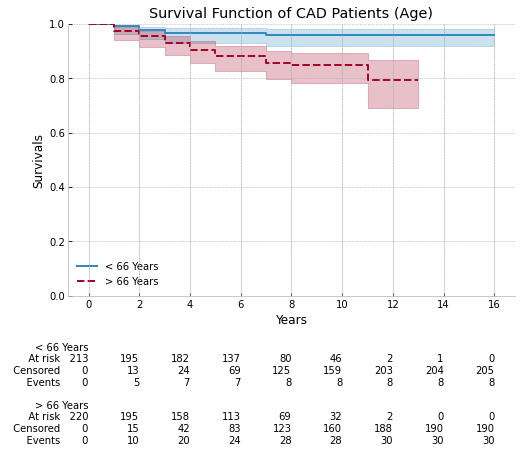

In [55]:
age_mean = df_6["Age (1)"].mean()

df_6_model_under_mean = df_6_model[df_6_model["Age (1)"] < age_mean]
df_6_model_above_mean = df_6_model[df_6_model["Age (1)"] > age_mean]

kmf1 = KaplanMeierFitter()
kmf1.fit(df_6_model_under_mean["duration"], event_observed=df_6_model_under_mean["observed"], label="< 66 Years")
kmf1.plot_survival_function()

kmf2 = KaplanMeierFitter()
kmf2.fit(df_6_model_above_mean["duration"], event_observed=df_6_model_above_mean["observed"], label="> 66 Years")
kmf2.plot_survival_function(linestyle="--")

plt.title('Survival Function of CAD Patients (Age)')
plt.xlabel("Years")
plt.ylabel("Survivals")
plt.ylim(0, 1)
plotting.add_at_risk_counts(kmf1, kmf2)